In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/5-flower-types-classification-dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
import os
import seaborn as sns
sns.set()

In [3]:
data_dir = '/kaggle/input/5-flower-types-classification-dataset/flower_images'

In [4]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [5]:
full_dataset = ImageFolder(root = data_dir, transform = transform)

In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [7]:
train_dataset, temp_dataset = random_split(full_dataset, [train_size, len(full_dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [9]:
for x, y in test_loader:
    print(f'Shape of X [N, C, H, W]: {x.shape}')
    print(f'Shape of y: {y.shape}{y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 80, 80])
Shape of y: torch.Size([32])torch.int64


In [10]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'Using {device} device')

Using cuda device


In [36]:
def plot_results(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label = 'Train')
    axes[0].plot(xs, val_losses, label = 'Validation')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label = 'Train')
    axes[1].plot(xs, val_accs, label = 'Validation')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [37]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [38]:
def val_step(model, criterion, dataloader, device = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [39]:
def train_model(model, n_epochs, optimizer, train_loader, val_loader, device = device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {val_loss:.3f} | Test Acc = {val_acc:.2f}%')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    plot_results(train_losses, train_accs, val_losses, val_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

In [40]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
classes = full_dataset.classes
print(f'Classes:\n{classes}')

Train dataset size: 3499
Test dataset size: 751
Validation dataset size: 749
Classes:
['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [41]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 1.215 | Train Acc = 51.19% | Test Loss = 1.241 | Test Acc = 49.93%: 100%|██████████| 30/30 [11:37<00:00, 23.23s/it]


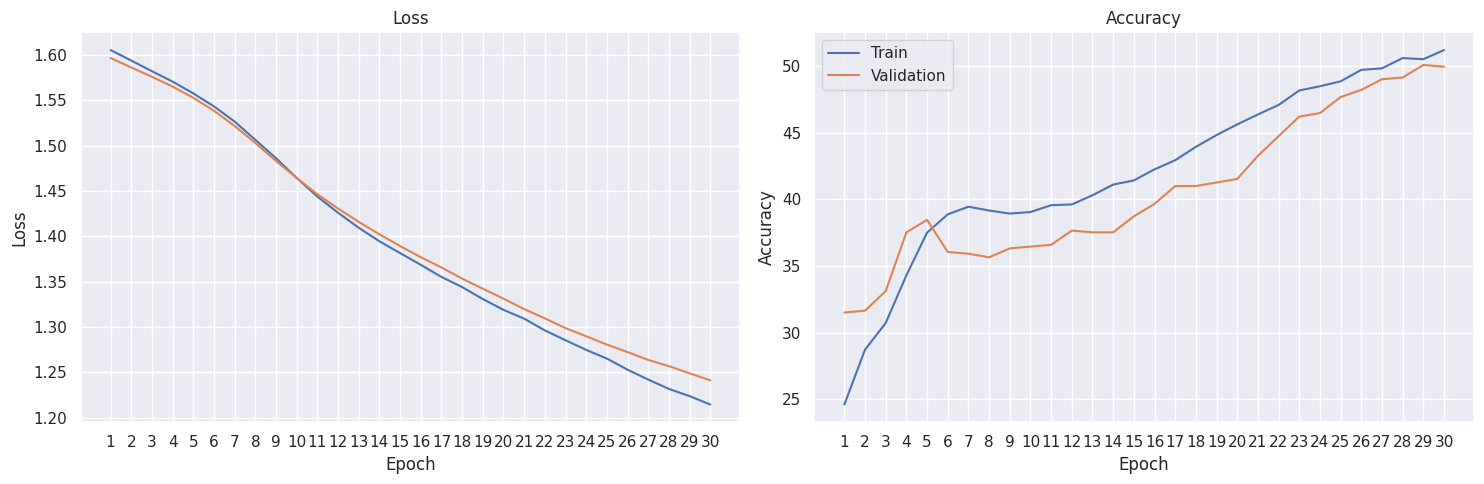

In [42]:
model = SimpleNN(input_size = 80*80*3, num_classes = len(classes)).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001)
result = train_model(model, 30, optimizer, train_loader, val_loader)

Train Loss = 0.180 | Train Acc = 93.77% | Test Loss = 1.455 | Test Acc = 73.70%: 100%|██████████| 20/20 [07:49<00:00, 23.49s/it]


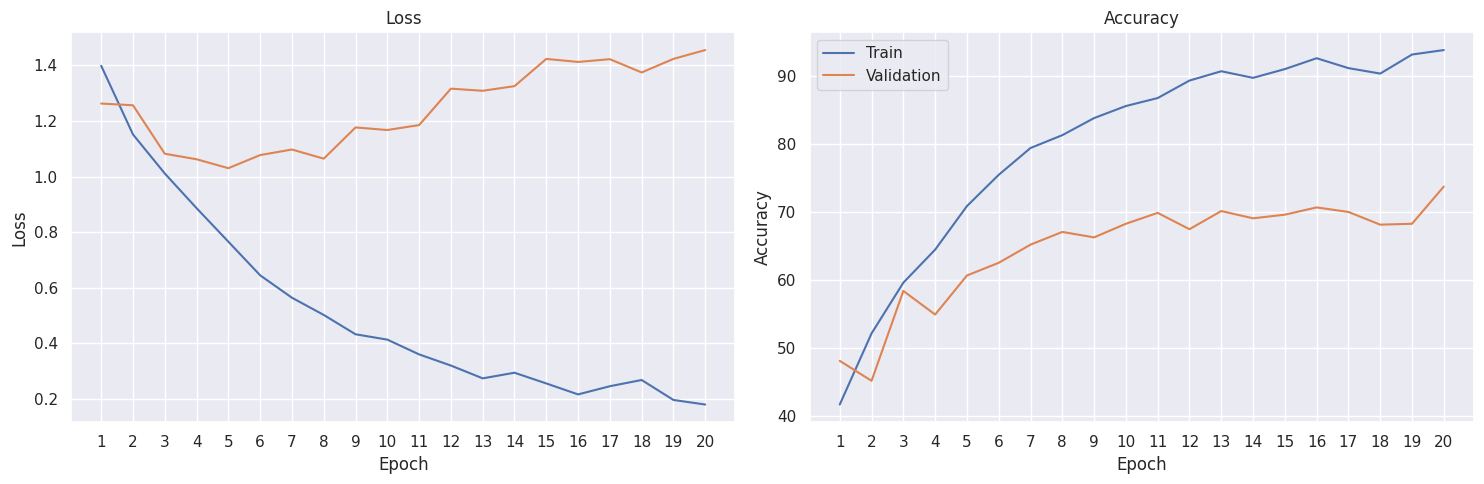

In [43]:
model = SimpleNN(input_size = 80*80*3, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [52]:
class SimpleNNDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNNDO, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                     nn.ReLU(), nn.Dropout(0.25), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Dropout(0.25), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Dropout(0.25), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.645 | Train Acc = 74.96% | Test Loss = 1.076 | Test Acc = 65.15%: 100%|██████████| 20/20 [07:41<00:00, 23.10s/it]


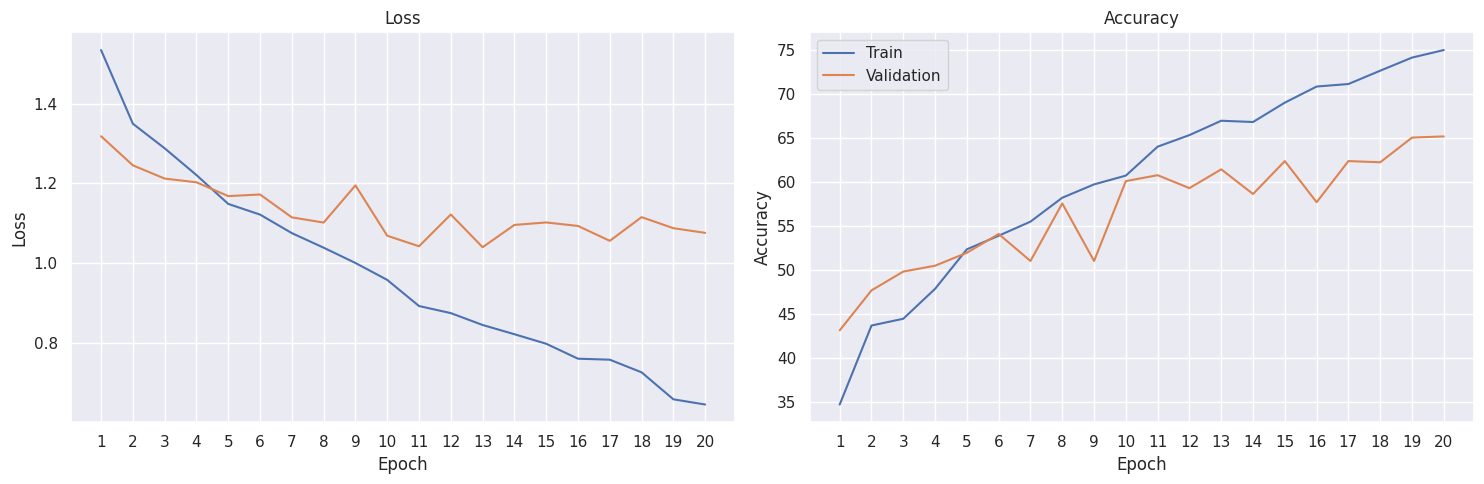

In [53]:
model = SimpleNNDO(input_size = 80*80*3, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [58]:
class SimpleNNDOBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNNDOBN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(), nn.Linear(input_size, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.25), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.25), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.25), nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss = 0.634 | Train Acc = 76.31% | Test Loss = 0.989 | Test Acc = 63.28%: 100%|██████████| 20/20 [07:51<00:00, 23.59s/it]


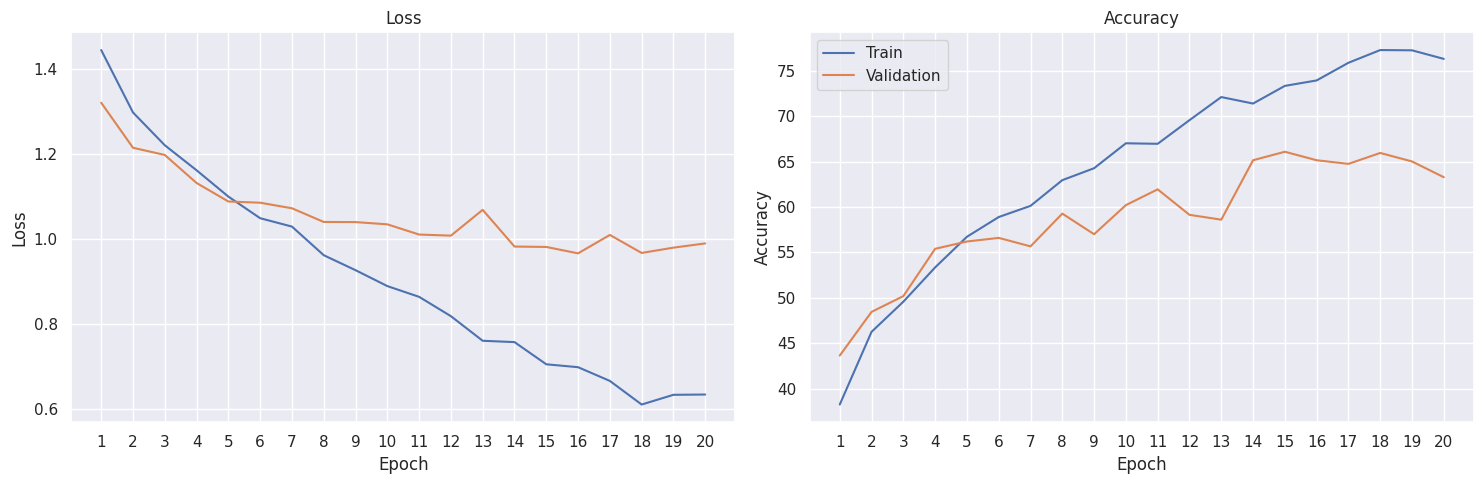

In [60]:
model = SimpleNNDOBN(input_size = 80*80*3, num_classes = len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)